# Google Play Store App Scraper

## Importing Libraries

In [1]:
import json
import re
import nltk
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from google_play_scraper import Sort, reviews, app, search
from nltk.corpus import wordnet
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import SnowballStemmer
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

%matplotlib inline
%config InlineBackend.figure_format='retina'

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

[nltk_data] Downloading package wordnet to /Users/alkis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alkis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Searching for apps in the Google Play

In [2]:
result_search = search(
    "Social Media",
    lang="en",  # defaults to 'en'
    country="gr",  # defaults to 'us'
    n_hits=30  # defaults to 30 (= Google's maximum)
)

### Printing all the result search

In [3]:
#Uncomment to see the results of the search
#result_search

## Getting the necessary info from the scrape

In [4]:
# Create a list of dictionaries with the extracted data
extracted_data = [{'appId': entry['appId'], 'title': entry['title'], 'score': entry['score'], 'genre': entry['genre'], 'icon': entry['icon']} for entry in result_search]

#Data Frame created from the list of dictionaries
df = pd.DataFrame(extracted_data)

df

,appId,title,score,genre,icon
0,com.snapchat.android,Snapchat,4.295431,Communication,https://play-lh.googleusercontent.com/KxeSAjPT...
1,com.instagram.android,Instagram,4.090300,Social,https://play-lh.googleusercontent.com/VRMWkE5p...
2,com.zhiliaoapp.musically,TikTok,4.382048,Social,https://play-lh.googleusercontent.com/LdBITldj...
3,com.pinterest,Pinterest,4.631640,Lifestyle,https://play-lh.googleusercontent.com/dVsv8Hc4...
4,com.facebook.katana,Facebook,3.912504,Social,https://play-lh.googleusercontent.com/KCMTYuiT...
5,com.twitter.android,X,4.047458,Social,https://play-lh.googleusercontent.com/A-Rnrh0J...
6,com.reddit.frontpage,Reddit,3.838656,Social,https://play-lh.googleusercontent.com/6Bexlvoh...
7,com.vkontakte.android,"VK: music, video, messenger",4.377358,Social,https://play-lh.googleusercontent.com/GntsGclz...
8,com.linkedin.android,LinkedIn: Jobs & Business News,4.372365,Business,https://play-lh.googleusercontent.com/kMofEFLj...
9,com.bereal.ft,BeReal. Your friends for real.,4.488584,Social,https://play-lh.googleusercontent.com/8Lu1K0dD...


### Just printing the logos of the scraped apps from the Google Play Store

In [5]:
html = "<div style='display: flex; flex-wrap: wrap;'>"
for index, row in df.iterrows():
    img_url = row['icon']
    html += f"<div style='margin: 10px;'><img src='{img_url}' style='width: 150px;'></div>"
html += "</div>"

HTML(html)

## App Reviews

### Testing for one app only

In [6]:
df['appId'][1]

'com.instagram.android'

In [7]:
# Sort.NEWEST (default): Sort reviews by the newest first.
# Sort.RATING: Sort reviews by the highest rating first.
# Sort.HELPFULNESS: Sort reviews by the most helpful first.

result_reviews, continuation_token = reviews(
    df['appId'][1],
    lang='en', # defaults to 'en'
    country='gr', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.NEWEST
    count=200, # defaults to 100
    filter_score_with=None # defaults to None(means all score)
)

result_reviews, _ = reviews(
    df['appId'][1],
    continuation_token=continuation_token # defaults to None(load from the beginning)
)

In [8]:
#Uncomment to see the results of the search
#result_reviews

In [9]:
result_reviews[4]

{'reviewId': '5ef549c2-8cda-4318-80a0-5ee34dbe9274',
 'userName': 'DINESH KUMAR SINGH',
 'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjWY9McmeXZbTS_hI--LDcNCka1J8Ob4Eb0ifzNCA--5jSA',
 'content': 'Too good',
 'score': 3,
 'thumbsUpCount': 0,
 'reviewCreatedVersion': '307.0.0.34.111',
 'at': datetime.datetime(2023, 11, 6, 18, 7, 51),
 'replyContent': None,
 'repliedAt': None,
 'appVersion': '307.0.0.34.111'}

### Going for all the apps in the aforementioned DataFrame

In [10]:
app_reviews = []

for ap in tqdm(df['appId']):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='gr',
        sort=sort_order,
        count= 200 if score == 3 else 100, #Going with that in order to create a balanced dataset, because most of the apps are towards 5 stars rating
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|███████████████████████████████████████████| 16/16 [01:40<00:00,  6.27s/it]


In [11]:
#Printing one just to be sure
print(app_reviews[0])

{'reviewId': '031a5fc8-966f-46b6-8546-f107b69b4eef', 'userName': 'Kristel Hoxha', 'userImage': 'https://play-lh.googleusercontent.com/a/ACg8ocJbJWuW7Cmob4mvrt88UwKert1nk74WW5E6rtSWouOS=mo', 'content': "Snapchat was a great app. But after so many updates it only seems to get worse. Is the AI feature and getting notifications when someone is typing really that necessary? It crashes every single time. Posting stories and texting has has became really frustrating. When I'm viewing a story it crashes and glitches by itself. Sometimes I don't even get notifications at all. And the 3d bitmojis look absolutely horrible. Video calling with friends has become really glitchy and the audio doesn't work.", 'score': 1, 'thumbsUpCount': 1728, 'reviewCreatedVersion': '12.62.1.53', 'at': datetime.datetime(2023, 11, 30, 20, 25, 50), 'replyContent': None, 'repliedAt': None, 'appVersion': '12.62.1.53', 'sortOrder': 'most_relevant', 'appId': 'com.snapchat.android'}


In [12]:
#Total Rows of the dataset // Total Reviews for all the apps
len(app_reviews)

19200

In [13]:
#Saving all the ratings into one csv file with the name reviews.csv
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

# Data Collection and Preprocessing

## Load and inspect the dataset

In [14]:
reviews_df = pd.read_csv('reviews.csv')

# Display the first few rows
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,031a5fc8-966f-46b6-8546-f107b69b4eef,Kristel Hoxha,https://play-lh.googleusercontent.com/a/ACg8oc...,Snapchat was a great app. But after so many up...,1,1728,12.62.1.53,2023-11-30 20:25:50,NaN,NaN,12.62.1.53,most_relevant,com.snapchat.android
1,007b588f-5290-4819-bed6-67d44c6e2141,Dude Man,https://play-lh.googleusercontent.com/a-/ALV-U...,"I loved this app, but ever since the last upda...",1,25465,12.60.0.58,2023-11-14 08:17:40,NaN,NaN,12.60.0.58,most_relevant,com.snapchat.android
2,09df455b-b7e0-4d4f-a6df-c60f90071a93,Max Wood,https://play-lh.googleusercontent.com/a-/ALV-U...,"Just updated my phone and suddenly, the filter...",1,15,12.62.1.53,2023-12-01 21:07:37,NaN,NaN,12.62.1.53,most_relevant,com.snapchat.android
3,41c07c62-9fa5-4d31-bb3c-a09dd9a7ae9f,Chris Monnin,https://play-lh.googleusercontent.com/a-/ALV-U...,Pretty much the only way I communicate. But re...,1,3217,12.60.0.58,2023-11-22 19:50:27,NaN,NaN,12.60.0.58,most_relevant,com.snapchat.android
4,f3239f0f-f95a-4272-91b2-eb1f5b72b3f9,Falah Aftab,https://play-lh.googleusercontent.com/a/ACg8oc...,"Firstly, I have noticed that the search functi...",1,2154,12.60.0.58,2023-11-17 00:37:52,NaN,NaN,12.60.0.58,most_relevant,com.snapchat.android


## Drop duplicate reviews based on content

In [15]:
reviews_df.drop_duplicates(subset='content', inplace=True)

## Remove columns that might contain PII or are not relevant

In [16]:
columns_to_drop = ['reviewId', 'userName', 'userImage', 'replyContent', 'repliedAt']
reviews_df.drop(columns=columns_to_drop, inplace=True)

## Clean, tokenize, stem, and remove stopwords from the review content

In [17]:
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    stemmer = SnowballStemmer(language='english')
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

reviews_df['content'].fillna("missing_content", inplace=True)
reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_tokenize)

# Indexing and Retrieval

## Build an inverted index

In [18]:
def build_inverted_index(df):
    inverted_index = defaultdict(set)
    for idx, content in df['cleaned_content'].items():
        for word in content.split():
            inverted_index[word].add(idx)
    return inverted_index

inverted_index = build_inverted_index(reviews_df)

## Positional Index

In [19]:
def build_positional_index(df):
    positional_index = defaultdict(lambda: defaultdict(list))
    for idx, content in df['cleaned_content'].items():
        for position, word in enumerate(content.split()):
            positional_index[word][idx].append(position)
    return positional_index

positional_index = build_positional_index(reviews_df)

## Use TF-IDF to rank reviews based on relevance

In [20]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reviews_df['cleaned_content'])

In [21]:
tfidf_matrix

<16493x13647 sparse matrix of type '<class 'numpy.float64'>'
	with 234048 stored elements in Compressed Sparse Row format>

# Query Processing

## Implement query expansion using synonyms (a simple example using NLTK's WordNet)

In [22]:
from nltk.corpus import wordnet

def expand_query(query):
    synonyms = set()
    for word in query.split():
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
    return " ".join(synonyms)

expanded_query = expand_query("example_query")

In [23]:
expanded_query

''

## Boolean Retrieval

In [24]:
def boolean_search(query, index):
    terms = [term for term in query.split() if term not in ['AND', 'OR', 'NOT']]
    sets = [set(index.get(term, {})) for term in terms]

    if 'AND' in query:
        result = set.intersection(*sets)
    elif 'OR' in query:
        result = set.union(*sets)
    elif 'NOT' in query:
        result = sets[0] - sets[1]
    else:
        result = sets[0]

    return result

# Example usage
results = boolean_search('performance AND good', inverted_index)

In [25]:
results

set()

# Sentiment Analysis

## Perform sentiment analysis

In [26]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

reviews_df['sentiment'] = reviews_df['content'].apply(get_sentiment)

In [27]:
reviews_df

,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,sortOrder,appId,cleaned_content,sentiment
0,Snapchat was a great app. But after so many up...,1,1728,12.62.1.53,2023-11-30 20:25:50,12.62.1.53,most_relevant,com.snapchat.android,snapchat great app updat wors ai featur get no...,negative
1,"I loved this app, but ever since the last upda...",1,25465,12.60.0.58,2023-11-14 08:17:40,12.60.0.58,most_relevant,com.snapchat.android,love app updat filter dont work filter alter s...,positive
2,"Just updated my phone and suddenly, the filter...",1,15,12.62.1.53,2023-12-01 21:07:37,12.62.1.53,most_relevant,com.snapchat.android,just updat phone sudden filter arent work prop...,positive
3,Pretty much the only way I communicate. But re...,1,3217,12.60.0.58,2023-11-22 19:50:27,12.60.0.58,most_relevant,com.snapchat.android,pretti way communic recent send messag snap wo...,positive
4,"Firstly, I have noticed that the search functi...",1,2154,12.60.0.58,2023-11-17 00:37:52,12.60.0.58,most_relevant,com.snapchat.android,first notic search function snapchat load prop...,positive
...,...,...,...,...,...,...,...,...,...,...
19193,NICE 👍,5,1,6.5.1,2023-12-02 23:03:00,6.5.1,newest,sg.bigo.live,nice,positive
19195,U want this,5,0,NaN,2023-12-02 22:45:23,NaN,newest,sg.bigo.live,u want,neutral
19196,This is something you have to experience for y...,5,0,NaN,2023-12-02 22:37:11,NaN,newest,sg.bigo.live,experi self,neutral
19198,Wow that's Is a Best platform,5,0,NaN,2023-12-02 22:32:56,NaN,newest,sg.bigo.live,wow that best platform,positive


## Aspect-Based Sentiment Analysis

In [28]:
aspects = ['performance', 'user interface', 'customer support']

def aspect_sentiment(text):
    aspect_sentiments = {}
    for aspect in aspects:
        if aspect in text:
            sentiment = get_sentiment(text)
            aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

reviews_df['aspect_sentiments'] = reviews_df['content'].apply(aspect_sentiment)

In [29]:
reviews_df

,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,sortOrder,appId,cleaned_content,sentiment,aspect_sentiments
0,Snapchat was a great app. But after so many up...,1,1728,12.62.1.53,2023-11-30 20:25:50,12.62.1.53,most_relevant,com.snapchat.android,snapchat great app updat wors ai featur get no...,negative,{}
1,"I loved this app, but ever since the last upda...",1,25465,12.60.0.58,2023-11-14 08:17:40,12.60.0.58,most_relevant,com.snapchat.android,love app updat filter dont work filter alter s...,positive,{}
2,"Just updated my phone and suddenly, the filter...",1,15,12.62.1.53,2023-12-01 21:07:37,12.62.1.53,most_relevant,com.snapchat.android,just updat phone sudden filter arent work prop...,positive,{}
3,Pretty much the only way I communicate. But re...,1,3217,12.60.0.58,2023-11-22 19:50:27,12.60.0.58,most_relevant,com.snapchat.android,pretti way communic recent send messag snap wo...,positive,{}
4,"Firstly, I have noticed that the search functi...",1,2154,12.60.0.58,2023-11-17 00:37:52,12.60.0.58,most_relevant,com.snapchat.android,first notic search function snapchat load prop...,positive,{}
...,...,...,...,...,...,...,...,...,...,...,...
19193,NICE 👍,5,1,6.5.1,2023-12-02 23:03:00,6.5.1,newest,sg.bigo.live,nice,positive,{}
19195,U want this,5,0,NaN,2023-12-02 22:45:23,NaN,newest,sg.bigo.live,u want,neutral,{}
19196,This is something you have to experience for y...,5,0,NaN,2023-12-02 22:37:11,NaN,newest,sg.bigo.live,experi self,neutral,{}
19198,Wow that's Is a Best platform,5,0,NaN,2023-12-02 22:32:56,NaN,newest,sg.bigo.live,wow that best platform,positive,{}


## Identify frequent aspects and determine sentiment

In [30]:
def identify_common_nouns(texts, n=10):
    all_words = nltk.word_tokenize(" ".join(texts))
    nouns = [word for word, pos in nltk.pos_tag(all_words) if pos in ['NN', 'NNS']]
    common_nouns = Counter(nouns).most_common(n)
    return [noun[0] for noun in common_nouns]

aspects = identify_common_nouns(reviews_df['content'])

In [31]:
aspects

['app',
 'time',
 'people',
 'video',
 'videos',
 'i',
 'phone',
 'problem',
 'account',
 'friends']

# Recommendation System

## Recommend apps based on user queries and review sentiments

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_apps(query):
    query_vector = vectorizer.transform([query])
    cosine_sim = cosine_similarity(query_vector, tfidf_matrix)
    recommended_apps = reviews_df.iloc[cosine_sim.argsort()[0, -5:]]
    return recommended_apps['appId']

recommended_apps_list = recommend_apps("camera quality")

In [33]:
recommended_apps_list

151       com.snapchat.android
10914            com.bereal.ft
707       com.snapchat.android
647       com.snapchat.android
13370    tv.twitch.android.app
Name: appId, dtype: object

In [34]:
def recommend_apps_analytical(query):
    query_vector = vectorizer.transform([query])
    cosine_sim = cosine_similarity(query_vector, tfidf_matrix)
    reviews_df['relevance'] = cosine_sim[0]
    relevant_reviews = reviews_df.sort_values(by='relevance', ascending=False).head(10)
    positive_reviews = relevant_reviews[relevant_reviews['sentiment'] == 'positive']
    return positive_reviews['appId']

recommended_apps_list_analytical = recommend_apps_analytical("camera quality")

In [35]:
recommended_apps_list_analytical

13370    tv.twitch.android.app
647       com.snapchat.android
707       com.snapchat.android
11345            com.bereal.ft
11351            com.bereal.ft
760       com.snapchat.android
79        com.snapchat.android
1490     com.instagram.android
Name: appId, dtype: object

# User Feedback Analysis

## Identify common issues or concerns

In [36]:
from collections import Counter

def common_issues(df, n=5):
    all_words = " ".join(df['cleaned_content']).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

top_issues = common_issues(reviews_df)

In [37]:
top_issues

[('app', 10818),
 ('like', 3865),
 ('use', 3426),
 ('video', 3101),
 ('just', 2732)]

## Deep Dive into Common Issues

In [38]:
def deep_dive_into_issues(df, n=5):
    issues = common_issues(df, n)
    issue_sentiments = {}
    for issue, _ in issues:
        sentiments = df[df['cleaned_content'].str.contains(issue)]['sentiment'].value_counts()
        issue_sentiments[issue] = sentiments.to_dict()
    return issue_sentiments

deep_dive_results = deep_dive_into_issues(reviews_df)

In [39]:
deep_dive_results

{'app': {'positive': 5404, 'negative': 2040, 'neutral': 565},
 'like': {'positive': 2050, 'negative': 712, 'neutral': 178},
 'use': {'positive': 2226, 'negative': 943, 'neutral': 154},
 'video': {'positive': 1326, 'negative': 525, 'neutral': 146},
 'just': {'positive': 1520, 'negative': 720, 'neutral': 101}}

# Topic Modeling

## Apply LDA to extract topics

In [40]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics)
topic_matrix = lda.fit_transform(tfidf_matrix)

def get_top_words(lda_model, feature_names, n_words=5):
    topics = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = top_words
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = get_top_words(lda, feature_names)

## Extract meaningful topics and understand their sentiment

In [41]:
def topic_sentiment(lda_model, tfidf_matrix, df):
    topic_matrix = lda_model.transform(tfidf_matrix)
    df['topic'] = topic_matrix.argmax(axis=1)
    topic_sentiments = df.groupby('topic')['sentiment'].value_counts().unstack().fillna(0)
    return topic_sentiments

topic_sentiments_df = topic_sentiment(lda, tfidf_matrix, reviews_df)

In [42]:
topic_sentiments_df

sentiment,negative,neutral,positive
topic,,,
0,2195,1922,4319
1,60,324,553
2,53,300,280
3,1353,704,4025
4,40,269,96


# Evaluation

In [43]:
def evaluate_recommendation(query):
    recommended_apps = recommend_apps_analytical(query)
    avg_sentiment = reviews_df[reviews_df['appId'].isin(recommended_apps)]['sentiment'].value_counts(normalize=True)
    return avg_sentiment

recommendation_evaluation = evaluate_recommendation("camera quality")

In [44]:
recommendation_evaluation

positive    0.583807
negative    0.225852
neutral     0.190341
Name: sentiment, dtype: float64

# Visualization

## Visualize sentiment distributions

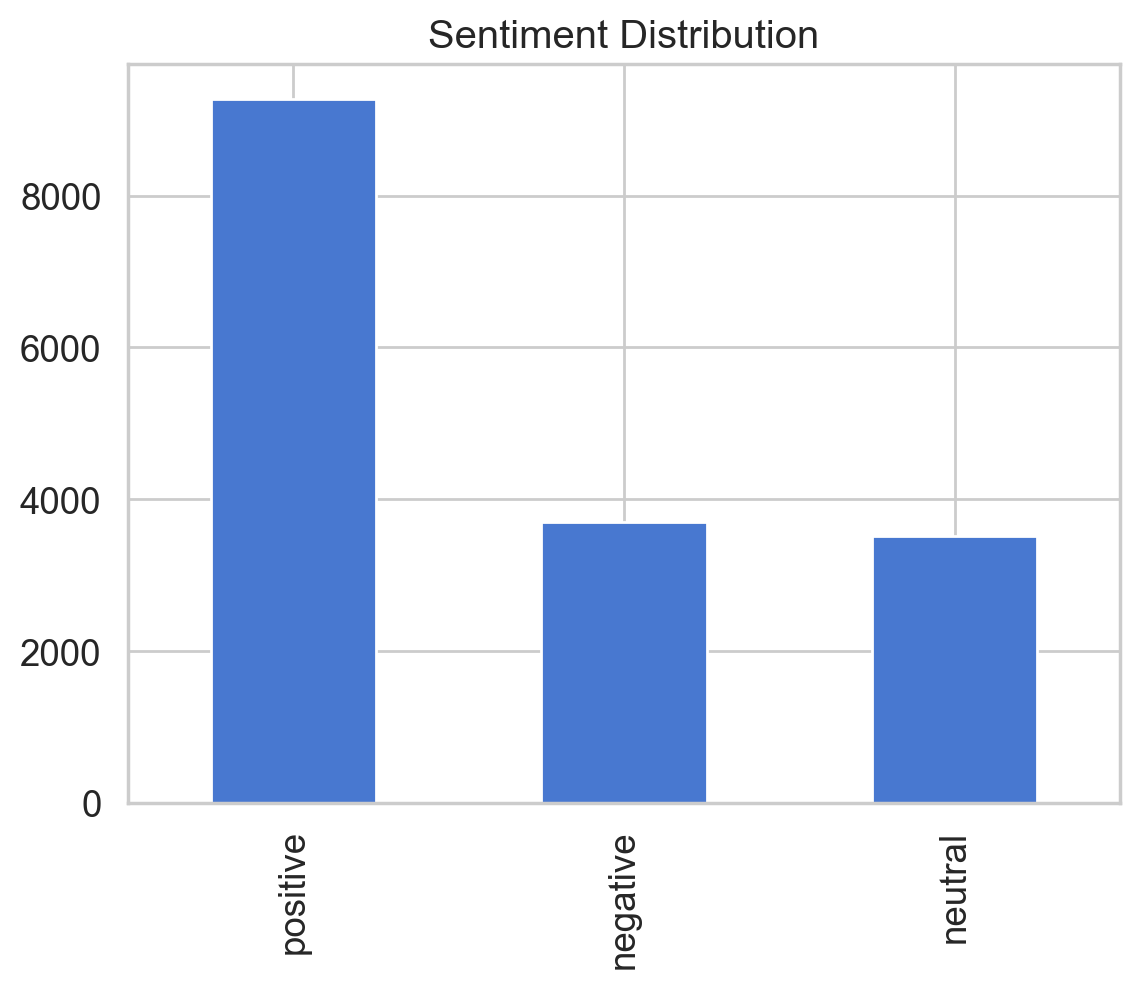

In [45]:
sentiment_counts = reviews_df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', title='Sentiment Distribution')
plt.show()

## Visualize Aspect Sentiments

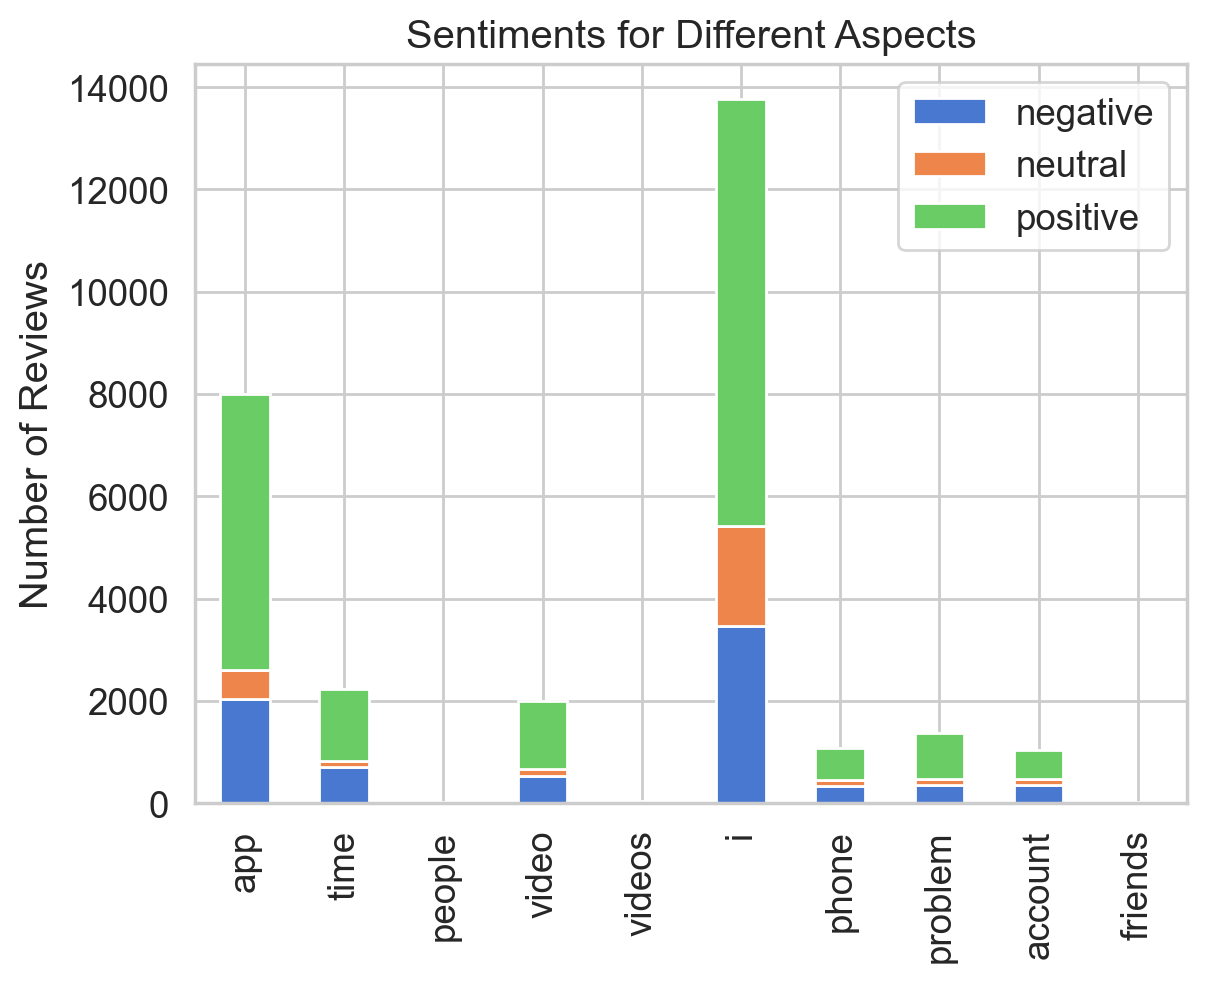

In [46]:
def plot_aspect_sentiments(df, aspects):
    aspect_counts = {aspect: df[df['cleaned_content'].str.contains(aspect)]['sentiment'].value_counts() for aspect in aspects}
    df_aspect = pd.DataFrame(aspect_counts).T.fillna(0)
    df_aspect.plot(kind='bar', stacked=True, title="Sentiments for Different Aspects")
    plt.ylabel('Number of Reviews')
    plt.show()

plot_aspect_sentiments(reviews_df, aspects)

# Machine Learning

## Clustering

In [47]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
reviews_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

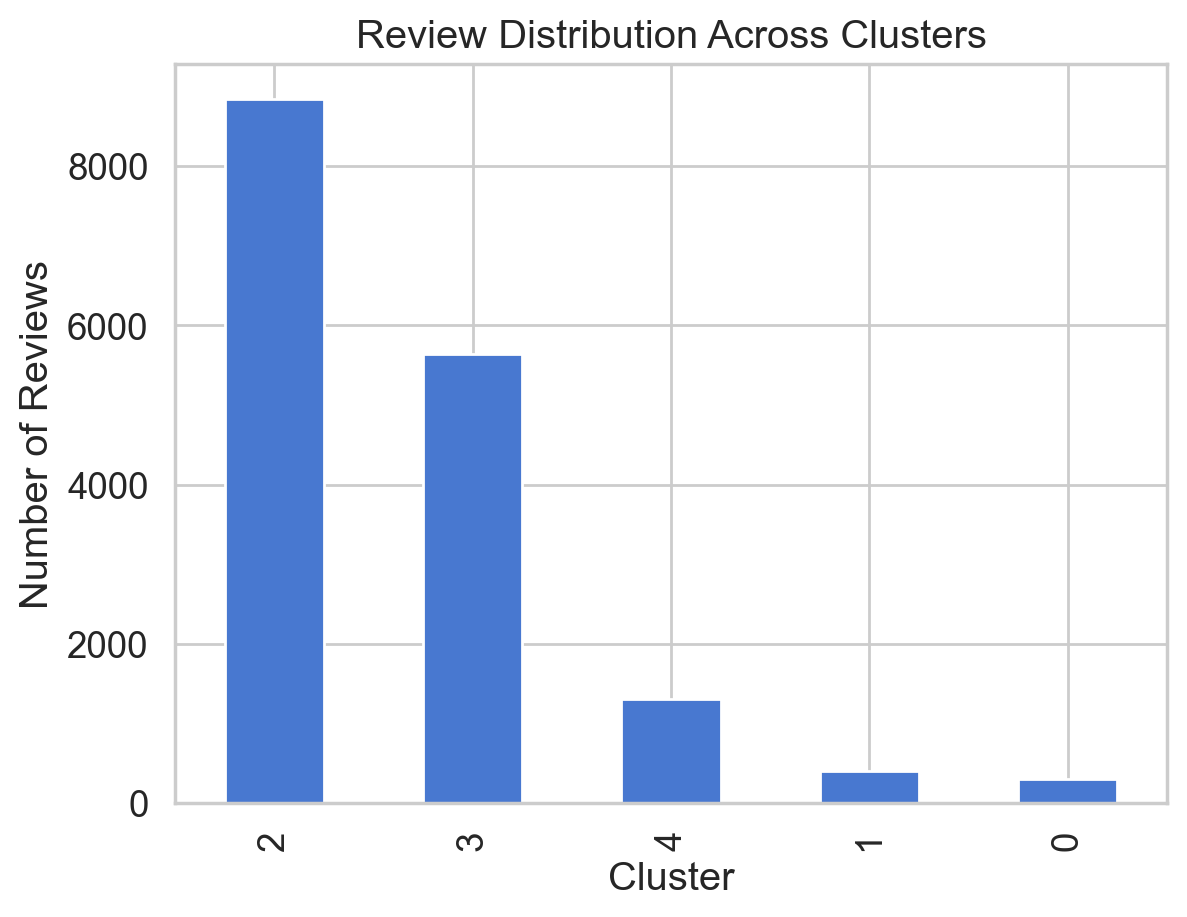

In [48]:
def plot_clusters(df):
    cluster_counts = df['cluster'].value_counts()
    cluster_counts.plot(kind='bar', title='Review Distribution Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Reviews')
    plt.show()

plot_clusters(reviews_df)

## Classification

In [49]:
X = tfidf_matrix
le = LabelEncoder()
y = le.fit_transform(reviews_df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

In [50]:
y_pred = clf.predict(X_test)
print(f"Classification Accuracy: {accuracy}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Accuracy: 0.6104880266747499

Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.04      0.08       717
     neutral       0.91      0.14      0.25       687
    positive       0.60      0.99      0.75      1895

    accuracy                           0.61      3299
   macro avg       0.77      0.39      0.36      3299
weighted avg       0.71      0.61      0.50      3299



# Deep Learning

## Word Embeddings

In [51]:
sentences = reviews_df['cleaned_content'].str.split().tolist()
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [52]:
def similar_words(word, model):
    if word in model.wv:
        return model.wv.most_similar(word)
    else:
        return f"The word '{word}' is not in the model's vocabulary."

word = "performance"
print(f"Words similar to '{word}':\n")
print(similar_words(word, model))

Words similar to 'performance':

The word 'performance' is not in the model's vocabulary.


In [53]:
def similar_words(word, model):
    if word in model.wv:
        return model.wv.most_similar(word)
    else:
        return f"The word '{word}' is not in the model's vocabulary."

word = "camera"
print(f"Words similar to '{word}':\n")
print(similar_words(word, model))

Words similar to 'camera':

[('longer', 0.9863739609718323), ('dot', 0.9846155047416687), ('exit', 0.9842963814735413), ('rotat', 0.9821885824203491), ('back', 0.9803205132484436), ('unrespons', 0.9779711365699768), ('forc', 0.9779521822929382), ('grey', 0.9754685759544373), ('proper', 0.9735727906227112), ('draft', 0.9735631942749023)]


# Similarity Measures | Jaccard Index

In [54]:
def jaccard_similarity(set1, set2):
    intersection_len = len(set1.intersection(set2))
    union_len = len(set1.union(set2))
    return intersection_len / union_len

In [55]:
set1 = set("The camera quality is excellent".split())
set2 = set("The camera is good".split())
similarity = jaccard_similarity(set1, set2)
print(f"Jaccard similarity between '{' '.join(set1)}' and '{' '.join(set2)}' is: {similarity}")

Jaccard similarity between 'camera is quality excellent The' and 'is good camera The' is: 0.5


## Intelligent Query Processing and Information Retrieval System for App Reviews Analysis

In [56]:
# Build the inverted index
inverted_index = build_inverted_index(reviews_df)

# Build the positional index
positional_index = build_positional_index(reviews_df)

# Create the TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reviews_df['cleaned_content'])

def simplified_expand_query(query):
    # Only expand to a limited set of synonyms or skip this entirely
    synonyms = set()
    for word in query.split():
        synsets = wordnet.synsets(word)
        if synsets:
            # Add only the first synonym to keep it simple
            synonyms.add(synsets[0].lemmas()[0].name().replace('_', ' '))
    return " ".join(synonyms) if synonyms else query

def flexible_boolean_search(query, index):
    # Search for any of the terms instead of all
    terms = query.split()
    document_ids = set()
    for term in terms:
        document_ids.update(index.get(term, set()))
    return document_ids

def process_query(query):
    expanded_query = simplified_expand_query(query)
    document_ids = flexible_boolean_search(expanded_query, inverted_index)
    if not document_ids:
        print("No documents found with expanded query. Trying with the original query...")
        document_ids = flexible_boolean_search(query, inverted_index)
    ranked_doc_ids = rank_documents(document_ids, query, tfidf_matrix, vectorizer)
    relevant_reviews = reviews_df.iloc[ranked_doc_ids] if ranked_doc_ids else pd.DataFrame()
    return relevant_reviews

def rank_documents(document_ids, query, tfidf_matrix, vectorizer):
    query_vector = vectorizer.transform([query])
    cosine_sim = cosine_similarity(query_vector, tfidf_matrix)
    
    # Ensure the document IDs are within the bounds of the TF-IDF matrix
    valid_doc_ids = [doc_id for doc_id in document_ids if doc_id < tfidf_matrix.shape[0]]
    
    ranked_documents = sorted([(doc_id, cosine_sim[0, doc_id]) for doc_id in valid_doc_ids], key=lambda x: x[1], reverse=True)
    return [doc_id for doc_id, _ in ranked_documents]

# Adjust the process_query function to handle empty DataFrame
def process_query(query):
    expanded_query = simplified_expand_query(query)
    document_ids = flexible_boolean_search(expanded_query, inverted_index)
    if not document_ids:
        print("No documents found with expanded query. Trying with the original query...")
        document_ids = flexible_boolean_search(query, inverted_index)
    ranked_doc_ids = rank_documents(document_ids, query, tfidf_matrix, vectorizer)
    relevant_reviews = reviews_df.iloc[ranked_doc_ids] if ranked_doc_ids else pd.DataFrame(columns=['content', 'sentiment'])
    return relevant_reviews

query = "great camera quality"
relevant_reviews = process_query(query)
print(relevant_reviews[['content', 'sentiment']])

                                                 content sentiment
151                        App forcing me to open camera   neutral
915                                                Great  positive
79     This has been happening for awhile now and I'v...  positive
11942                                        Great app 👌  positive
70     I use to use this allv the time but since the ...  negative
...                                                  ...       ...
4337                            Christen Stewart six Com   neutral
4340   has glitches when you have a board with multip...   neutral
8946   I would suggest if it can have in-app translat...  positive
19048  Very nice and friendly staff all the people th...  positive
4356                                            ɴɪᴄᴇᴇᴇᴇᴇ   neutral

[1324 rows x 2 columns]
